In [1]:
# Imports
import torch
torch.cuda.empty_cache()

import hr_dv2.transform as tr
from hr_dv2.utils import *
from hr_dv2.segment import fwd_and_cluster, semantic_segment, get_attn_density

import numpy as np
from sklearn.cluster import KMeans
from skimage.color import label2rgb
from PIL import Image
import matplotlib.pyplot as plt


PATCH_SIZE  = 14
FEAT_DIM = 384

In [2]:
from hr_dv2 import HighResDV2, torch_pca

#net = HighResDV2("dinov2_vits14_reg", 4, pca_dim=128, dtype=torch.float16)
net = HighResDV2("dino_vits8", 4, pca_dim=128, dtype=torch.float16)
net.cuda()
net.eval()
pass

Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dino_main


In [3]:
path = "data/v2.png"
_img = Image.open(path)
_h, _w = _img.height, _img.width
t = tr.closest_crop(_h, _w, 16, True)

#t = tr.get_input_transform(224 * 2, 224 * 2)

img_tensor, img = tr.load_image(path, t)
img_arr = np.array(img)
h, w, c = img_arr.shape


img_tensor.to(torch.float16)
img_tensor = img_tensor.cuda()

In [4]:
shift_dists = [i for i in range(1, 3)]
fwd_shift, inv_shift = tr.get_shift_transforms(shift_dists, 'Moore')
fwd_flip, inv_flip = tr.get_flip_transforms()
fwd, inv = tr.combine_transforms(fwd_shift, fwd_flip, inv_shift, inv_flip)

net.set_transforms(fwd, inv)

attn_choice = "o"
feats_attn_tensor = net.forward_sequential(img_tensor, attn_choice=attn_choice)
print(feats_attn_tensor.shape)
if attn_choice != "none":
    feats, attn = feats_attn_tensor[0, :-6, :, :], feats_attn_tensor[0, -6:, :, :]
else:
    feats = feats_attn_tensor[0]

torch.Size([1, 390, 320, 496])


In [5]:
pcaed = torch_pca(feats, 3, max_samples=50000)
pcaed = tr.to_numpy(pcaed)

In [6]:
rescaled = rescale_pca(pcaed)

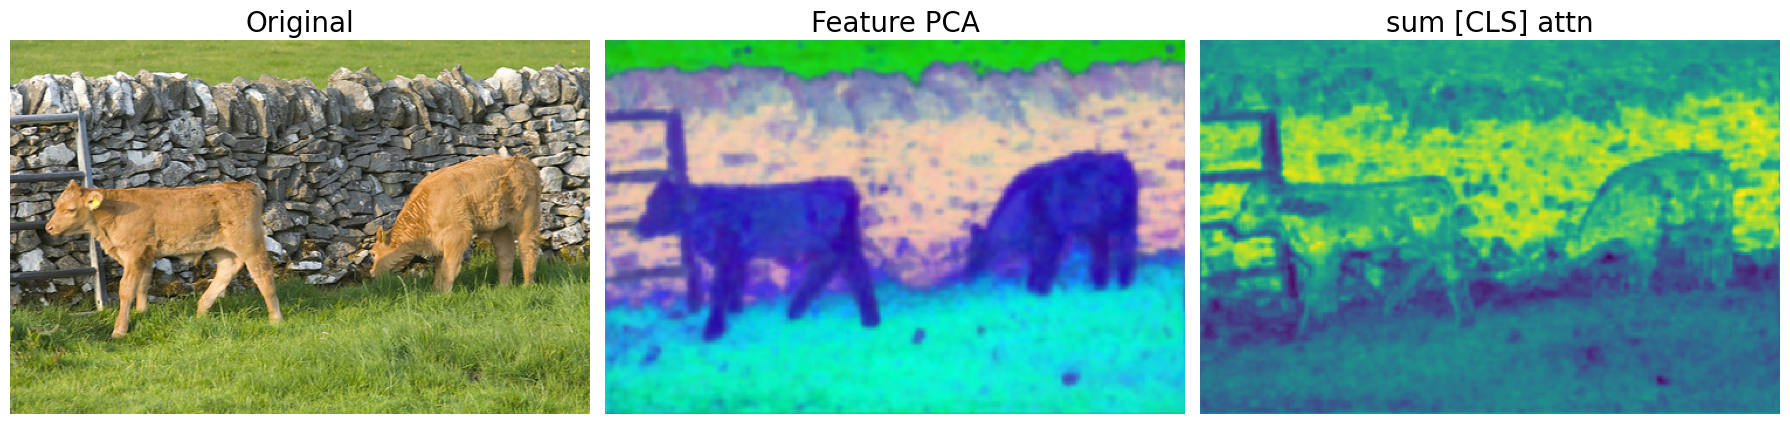

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(18, 8)

axs[0].imshow(img)
axs[1].imshow(rescaled.reshape(h, w, 3), interpolation='nearest')
axs[2].imshow(np.sum(tr.to_numpy(attn), axis=0) , interpolation='nearest')

titles = ["Original", "Feature PCA", "sum [CLS] attn"]
for i, ax in enumerate(axs):
    ax.set_axis_off()
    ax.set_title(titles[i], fontsize=20)
plt.tight_layout()

In [8]:
c, fh, fw = feats.shape
features = tr.to_numpy(feats, batched=False)
reshaped = features.reshape((c, fh * fw)).T

attention = tr.to_numpy(attn, batched=False)

normed = normalise_pca(reshaped)
n_pix = normed.shape[0]
random_inds = np.random.choice(np.arange(n_pix), min(60000, n_pix), False)
print(normed.shape)
cluster = KMeans(n_clusters=80, n_init="auto", max_iter=100)
cluster.fit(normed[random_inds])
labels = cluster.predict(normed)
centroids = cluster.cluster_centers_

(158720, 384)


In [9]:
semantic_seg = semantic_segment(reshaped, attention, labels, centroids, img_arr)

(158720, 384) (158720, 384, 1) (1, 384, 4)


In [10]:
sum_cls = np.sum(attention, axis=0)
amap, dens = get_attn_density(semantic_seg, sum_cls)

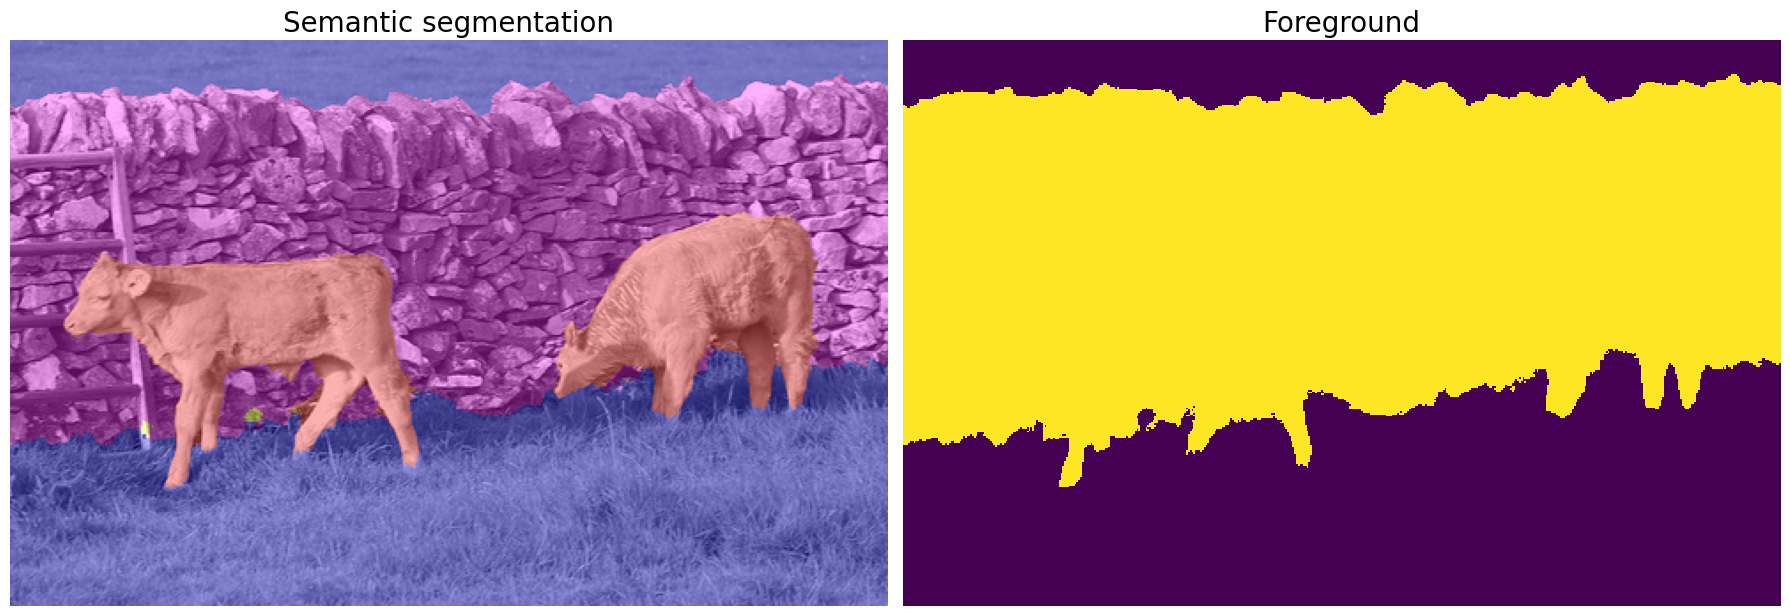

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(18, 8)

axs[0].imshow(label2rgb(semantic_seg, img_arr, bg_label=-1))
axs[1].imshow(amap > np.mean(dens), interpolation='nearest')

titles = ["Semantic segmentation", "Foreground", "sum [CLS] attn"]
for i, ax in enumerate(axs):
    ax.set_axis_off()
    ax.set_title(titles[i], fontsize=20)
plt.tight_layout()